# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [74]:
# !pip install Unidecode
# !pip install gensim
# !pip install python-Levenshtein

     |████████████████████████████████| 50 kB 3.4 MB/s eta 0:00:01
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp38-cp38-macosx_10_15_x86_64.whl size=81804 sha256=ffa978cee041cb994b86d827235ad03854ed0f65b55c428049c6e2b951a2aef7
  Stored in directory: /Users/alexisgourdol/Library/Caches/pip/wheels/d7/0c/76/042b46eb0df65c3ccd0338f791210c55ab79d209bcc269e2c7
Successfully built python-Levenshtein


In [182]:
from unidecode import unidecode
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [21]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [22]:
data.iloc[18].verse # the strings has some unicode weird characters e.G. \u2005was\u2005

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [23]:
print(data.shape)
data.verse = data.verse.apply(unidecode)
print(data.shape)
print(data.iloc[18].verse)  # should be cleaned

(3975, 2)
(3975, 2)
Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah


❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [24]:
data.verse.duplicated().sum() # 946 duplicated lyrics

946

In [27]:
data.drop_duplicates(subset='verse', inplace=True)

In [28]:
#3031 rows × 2 columns without subset vs 3029 rows × 2 columns with subset

In [29]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [30]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     777
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [31]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [32]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [33]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


In [36]:
tokenizer_drake.index_word

{1: 'i',
 2: 'you',
 3: 'the',
 4: 'and',
 5: 'to',
 6: 'a',
 7: 'it',
 8: 'me',
 9: "i'm",
 10: 'my',
 11: 'that',
 12: 'in',
 13: 'on',
 14: 'like',
 15: 'know',
 16: 'for',
 17: 'they',
 18: 'yeah',
 19: 'just',
 20: 'with',
 21: 'all',
 22: 'of',
 23: 'up',
 24: 'is',
 25: 'got',
 26: 'but',
 27: "don't",
 28: 'this',
 29: "it's",
 30: 'we',
 31: 'get',
 32: 'your',
 33: 'be',
 34: 'when',
 35: 'so',
 36: 'no',
 37: 'shit',
 38: 'what',
 39: 'now',
 40: 'do',
 41: 'out',
 42: 'she',
 43: 'go',
 44: "ain't",
 45: 'if',
 46: 'girl',
 47: "that's",
 48: 'at',
 49: 'man',
 50: 'back',
 51: 'from',
 52: 'was',
 53: 'oh',
 54: 'time',
 55: 'down',
 56: 'how',
 57: 'niggas',
 58: 'never',
 59: 'love',
 60: 'one',
 61: 'right',
 62: 'been',
 63: "can't",
 64: 'say',
 65: 'nigga',
 66: 'can',
 67: 'not',
 68: 'need',
 69: 'tell',
 70: 'still',
 71: "'cause",
 72: 'make',
 73: 'some',
 74: 'baby',
 75: 'her',
 76: 'way',
 77: 'gotta',
 78: 'see',
 79: 'wanna',
 80: 'too',
 81: 'take',
 82: '

In [37]:
tokenizer_drake.__dict__.keys()

dict_keys(['word_counts', 'word_docs', 'filters', 'split', 'lower', 'num_words', 'document_count', 'char_level', 'oov_token', 'index_docs', 'word_index', 'index_word'])

👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [38]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [39]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.26% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [46]:
data["seq"] = [tf.keras.preprocessing.text.text_to_word_sequence(_) for _ in data.verse]

In [47]:
data.head()

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

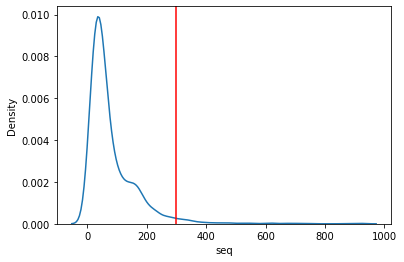

In [56]:
sns.kdeplot(data.seq.apply(len))
plt.axvline(x=300, c='red'); # yes, 300 is very reasonable

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [60]:
data.seq.apply(keep_300)

0                             [ayy, woah, ayy, ayy, yeah]
1       [i'm, makin', a, change, today, the, liquor, b...
2       [i, can't, just, be, with, you, and, only, you...
3       [well, summer, all, i, did, was, rest, okay, a...
4       [i'm, makin', a, change, today, the, liquor, b...
                              ...                        
3970    [dame, was, like, yo, you, got, a, deal, with,...
3971    [then, one, day, i, just, went, ahead, and, pl...
3972           [i, ain't, gonna, front, it's, kinda, hot]
3973    [like, they, still, weren't, looking, at, me, ...
3974    [you, gotta, be, under, an, umbrella, you'll, ...
Name: seq, Length: 3029, dtype: object

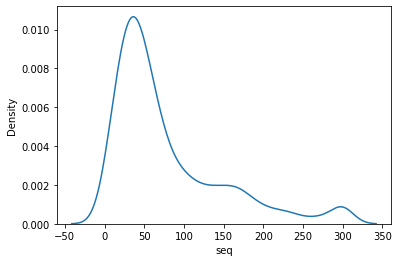

In [62]:
def keep_300(x: list) -> list:
    return x[:300]

sns.kdeplot(data.seq.apply(keep_300).apply(len));

In [70]:
data.seq = data.seq.apply(keep_300)

#check of max value
print(data.seq.apply(keep_300).apply(len).max())

data.head()

300


,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [77]:
from gensim.models import Word2Vec
word2vec = Word2Vec(sentences=data.seq, vector_size=100, epochs=50)

In [122]:
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [125]:
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [126]:
data["embed"] = embedding(word2vec, list(data.seq))

In [127]:
print(len(data.seq.loc[0]))
print(data.embed.loc[0].shape)

print(len(data.seq.loc[100]))
print(data.embed.loc[100].shape)

print(len(data.seq.loc[2500]))
print(data.embed.loc[2500].shape)

print(len(data.seq.loc[700]))
print(data.embed.loc[700].shape)

5
(5, 100)
57
(56, 100)
137
(128, 100)
61
(61, 100)


In [128]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [129]:
data.embed.head().apply(len).to_frame()

,embed
0,5
1,59
2,89
3,63
4,60


In [135]:
X = pad_sequences(data.embed, dtype='float32', padding='post', value=0)
X.shape

(3029, 299, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [153]:
artists_order = pd.get_dummies(data.artist).columns
artists_order

Index(['Drake', 'Ed Sheeran', 'Kanye West'], dtype='object')

In [148]:
y = pd.get_dummies(data.artist).to_numpy()
print(y.shape)
y

(3029, 3)


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

👉 We train/test split the dataset below for you

In [149]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [150]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [154]:
print(artists_order)
y.sum(axis=0)

Index(['Drake', 'Ed Sheeran', 'Kanye West'], dtype='object')


array([1391,  861,  777], dtype=uint64)

In [172]:
# Let's predict always Drake

In [173]:
y_baseline = np.tile([1,0,0], reps=(3029,1))
print(y_baseline.shape)
print(y_baseline[:10])
print('...')

(3029, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
...


In [174]:
score_baseline = y.sum(axis=0)[0] / y.sum(axis=0).sum()

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [186]:
X_train.shape

(2423, 299, 100)

In [187]:
vocab_size = X_train.shape[1]
vocab_size

299

In [188]:
embedding_dimension = X_train.shape[2]
embedding_dimension

100

In [201]:
model = Sequential()
model.add(layers.Masking(mask_value=0))
model.add(layers.LSTM(units=10, activation='tanh')) # tanh
model.add(layers.Dense(1))
model.add(layers.Dense(3, activation='softmax'))

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [219]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop')

model.compile(loss='binary_crossentropy', optimizer=optimizer , metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=16, validation_split=0.2, epochs=10, verbose=0);

❓ **Plot the training and validation losses through training**

In [220]:
model.history.history

{'loss': [0.48286664485931396,
  0.42323824763298035,
  0.39221152663230896,
  0.3732449412345886,
  0.35657837986946106,
  0.34030240774154663,
  0.32958874106407166,
  0.3102766275405884,
  0.31128740310668945,
  0.2916257977485657],
 'accuracy': [0.6455108523368835,
  0.6888545155525208,
  0.7115582823753357,
  0.7162022590637207,
  0.727554202079773,
  0.7481940388679504,
  0.7631579041481018,
  0.7956656217575073,
  0.806501567363739,
  0.8359133005142212],
 'val_loss': [0.5518283843994141,
  0.48613297939300537,
  0.5378615260124207,
  0.5107419490814209,
  0.5253013968467712,
  0.5382227897644043,
  0.5612010359764099,
  0.5772908329963684,
  0.6035664677619934,
  0.6349676847457886],
 'val_accuracy': [0.5835051536560059,
  0.6309278607368469,
  0.6082473993301392,
  0.6144329905509949,
  0.6288659572601318,
  0.6474226713180542,
  0.6371133923530579,
  0.6288659572601318,
  0.6515464186668396,
  0.6350515484809875]}

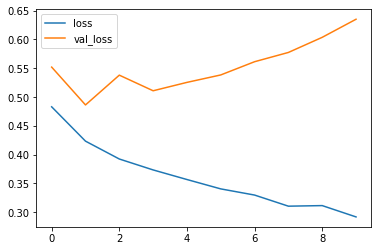

In [222]:
# Plot below your train/val loss history ====> learning_rate=0.01 
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend();

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [223]:
model.evaluate(X_test, y_test, verbose=1)

19/19 [==============================] - 1s 26ms/step - loss: 0.7114 - accuracy: 0.6320


[0.71136075258255, 0.632013201713562]

In [225]:
score_test = 0.6320

🧪 **Send your results below**

In [226]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()